# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [98]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = 0.0

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 7

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = 1
params['c_u'] = 0.1

In [99]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl) - 1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    y = np.zeros((num_samples, num_classes))
    l_idx = []
    u_idx = []
    for i in range(num_samples):
        label = int(Y[i])
        if label:  # Labeled node
            l_idx.append(i)
            y[i][label - 1] = 1
        else: # Unlabeled node
            u_idx.append(i)
    l_idx = np.array(l_idx)
    u_idx = np.array(u_idx)

    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f = np.zeros(y.shape)
        f_l = y[l_idx]
        f[l_idx] = f_l
        f_u = - np.linalg.inv(L[u_idx][:, u_idx]) @ (L[u_idx][:, l_idx] @ f_l)
        f[u_idx] = f_u

    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        C = np.zeros(num_samples)
        C[l_idx] = params["c_l"]
        C[u_idx] = params["c_u"]
        f = np.linalg.inv(np.diag(1/C) @ L + np.eye(num_samples)) @ y

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1
    return labels, f


In [100]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l//2, per_class=True)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(X, params["laplacian_regularization"], var=params["var"], eps=params["eps"], k=params["k"], laplacian_normalization=params["laplacian_normalization"])

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

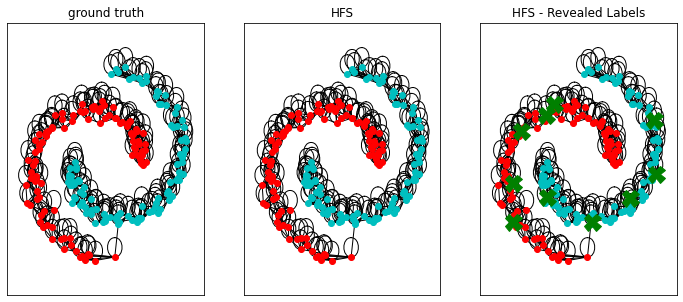

Soft=False, Accuracy=1.0


In [101]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [102]:
np.random.seed(42)
for _ in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, **params)
    
mask_labels  # check parameters

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


<function helper.mask_labels(Y, l, per_class=False)>

With 4 unmasked nodes provided to the algorithm, the 4 nodes, picked randomly, could be in the same class and have the same labels. In this case, the algorithm cannot work and gives the error `"only one class in training data!"`.

To prevent all unmasked nodes from having the same label, we can use : 
\
`
Y_masked = mask_labels(Y, l//2, per_class=True)
`

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

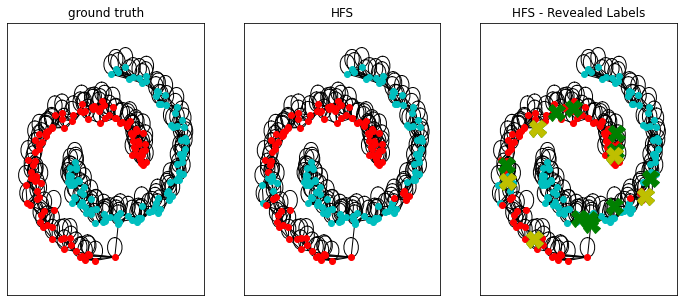

Soft=False, Accuracy=0.93


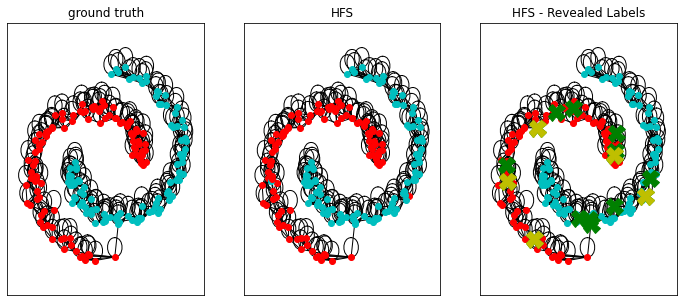

Soft=True, Accuracy=0.99


In [103]:
# Comparing
seed = 10  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

Soft HFS performs better than hard HFS and is able to relabel outliers introduced by noise.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

We define the target vector, which contains hot-encoder representing labels of each nodes.

``y = np.zeros((n x num_classes))`` 

Then $f$ is in $\mathbb{R}^{n * N}$, with N the number of classes. To produce labels, we choose for each node the label with the higher probability using : 

``labels = np.argmax(f, axis=1) + 1``

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 


The best accuracy score for small dataset : 0.84

with these parameters : 

``params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.10
params_face_rec['var'] = 100.0
params_face_rec['eps'] = None
params_face_rec['k'] = 5
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 1
params_face_rec['c_u'] = 0.1``


The best accuracy score for augmented dataset : 0.63

with parameters : 

``params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.10
params_face_rec['var'] = 100.0
params_face_rec['eps'] = None
params_face_rec['k'] = 10
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 0.95
params_face_rec['c_u'] = 0.05``


### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

Adding more unlabelled data does not improve the performance in this case, but adding labelled images would. With the augmented dataset, the graph has a smaller proportion of labelled nodes, the task is therefore harder. 

In [104]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [105]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.10
params_face_rec['var'] = 100.0
params_face_rec['eps'] = None
params_face_rec['k'] = 10
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 0.95
params_face_rec['c_u'] = 0.05

In [106]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

C:\Users\marin\AppData\Local\Temp/ipykernel_43508/594677276.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


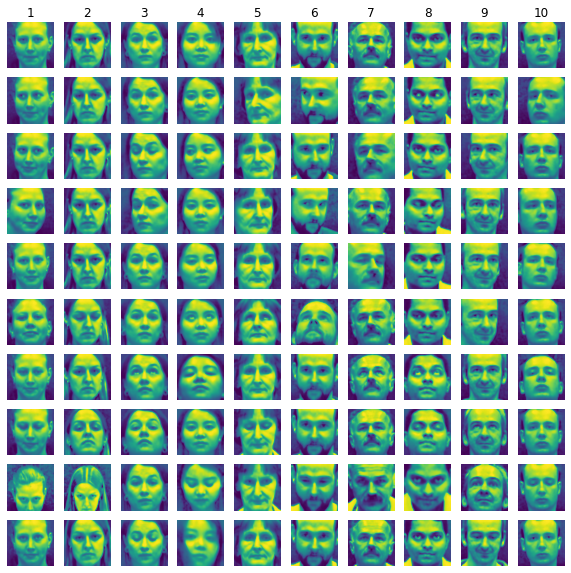

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [107]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# # 50 images per person
# images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
# plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [109]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.84
[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.  1.  2.  0.  4.  0.  0.  7.  0.
  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  9.  0.  1.  0.  3.  0.  0.  6.
  0.  0.  9. 10.  0.  0.  0.  4.  5.  6.  0.  8.  0.  0.  0.  0.  0.  4.
  5.  0.  0.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.  0.  9. 10.  0.  0.
  0.  0.  5.  6.  7.  0.  0. 10.  0.  0.  0.  0.  5.  0.  0.  8.  9. 10.
  0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  3  9  7  8  9  9  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6 10  8
  1 10 10  2  4  4  5  4  7  8  1 10  1  2  3 10  5  6  7  3  9 10  1  2
 10  4  5  6  7  3  9 10  4  4  3  4  5  6  8  8  9 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2
  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9

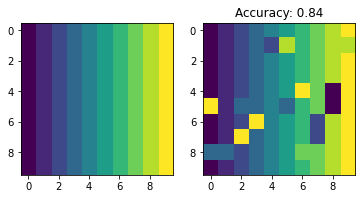

In [110]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.



We label a faces as unknown if the largest probability per label is smaller than a given threshold, here 0.5.



In [111]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [112]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 0.10
params_online_ssl['var'] = 500.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = 15
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 1
params_online_ssl['c_u'] = 0.1

In [113]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            c_1 = np.argmin(self.centroids_distances) // self.centroids.shape[0]
            c_2 = np.argmin(self.centroids_distances) % self.centroids.shape[0]

            if self.taboo[c_1] and not self.taboo[c_2]:
                c_rep = c_1
                c_add = c_2
            elif not self.taboo[c_1] and self.taboo[c_2]:
                c_rep = c_2
                c_add = c_1
            elif not self.taboo[c_1] and not self.taboo[c_2]:
                if self.V[c_2] <= self.V[c_1]:
                    c_rep = c_1
                    c_add = c_2
                else :
                    c_rep = c_2
                    c_add = c_1
            else:
                raise ValueError('Two centroids in self.taboo')


            """
            Update data structures: self.centroids and self.V
            """
            # ...
            self.centroids[c_add] = face
            self.V[c_rep] += self.V[c_add]
            self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W = V @ build_similarity_graph(self.centroids, var=params_online_ssl["var"], eps=params_online_ssl["eps"], k=params_online_ssl["k"]) @ V
        L = build_laplacian(W, params_online_ssl["laplacian_normalization"])
        Q = L + params_online_ssl["laplacian_regularization"] * np.eye(W.shape[0])   # regularized Laplacian

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
        
        # handle unknown faces
        best_score = max(map(lambda ll: ll[1], label_scores))
        if best_score < 0.5:
            label_scores = [("unknown", 1 - best_score)]

        return label_scores
      


In [119]:
# create_user_profile('beyonce')         # choose your names here :)
# create_user_profile('marine')
online_face_recognition(['marine', 'beyonce', 'hugo'], IncrementalKCenters, n_pictures=15)

Profile found with 10 images.
Profile found with 10 images.
Profile found with 9 images.
saved
Image saved at results\frame.png


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification
    

We can classify faces as known or unknown for each new sample. We can therefore proceed by tasks. Each novel task contains a number of $n_t$ novel classes with only a few training samples per class. In this example, the first task would be composed of class 'beyonce' and 'marine'. The next task could be composed of classes 'bob', 'alice' and 'jean-paul'. There is no overlap between classes in different tasks.

We use Online HFS with Graph Quantization for each tasks, and all samples defined as unknown are used for the next task. The algorithm is then sequentially given access to the data of each task. Importantly, after transitioning from one task to the next, the data from the previous task is no longer available.

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

__Supervised vs Semi-supervised with few labelled data__

This experiment is performed on 10faces (100 images).

I decided to train a convolutional neural network on images to compare with the method developped in this algorithm. 
4 images per person are used for training (which represent 2/5 of the dataset),this dataset is labelled. The rest of the images are used for testing and have no label. We use this same ratio to split our data.


If we use a pre-trained model such as Resnet, we get 60% accuracy on the test dataset.
On the other hand, if we do not use the pre-trained model, the model is only trained on 4 images per person and the accuracy is really low, only 22% of correct answers. 

The unsupervised method perfoms better than the CNN, pretrained or not, with 84% of correct answers on the unlabelled dataset. The semi-supervised learning technique works better than a fully supervised method when there is only few labelled data.


__Supervised vs Semi-supervised with more labelled data__

This experiment is performed on the augmented dataset (500 images). 450 images are used for training, 50 for testing.

Then, we use 9/10 of the augmented dataset to train our model, with labels. We get good results, between 87% and 94% of accuracy, therefore the pre-trained model outperforms semi-supervised methods. The performance of the Resnet model, including it's stability, could be improved with carefully chosen hyperparameters. 

The HFS algorithm performs badly with a lot of unlabelled data on the augmented dataset, as seen previously. An interesting test would be to give more labelled images to the HFS algorithm, and to compare models performances with the same large number of labelled samples.



__Conclusion__

To conclude, semi-supervised learning is especially interesting when we have very few labelled data. Then, the unlabelled data can give information about the structure of the dataset. On the other hand, if we have a large amount of labelled data, convolutionnal neural network performs better. 

Convolutionnal neural networks need has much labelled data as possible, therefore it is useless to hide labels, and the dataset performs poorly with few samples. 


Using pretrained convolutionnal networks, which have already been trained on a large amount of images can help imrpove results when we don't have enough images. 


In [266]:
train_size = 9/10 #define split_ratio
pretrained = True #Change HERE if pretrained or not
augmented = True


n_class = 10
SIZE = (96,96)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_s = 6
num_epochs = 12
criterion = nn.CrossEntropyLoss()
max_lr = 0.00005


In [267]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import torchvision as tv
from torchvision import datasets, transforms

def train_val_dataset(dataset, y):
  """ 
  Split the dataset in a training and validation test with the ratio val_split. 
  Input : dataset, val_split
  Output : Dictionnary dataset = {'train'; 'val'}
  """
  train_idx, val_idx = train_test_split(list(range(len(dataset))), train_size=train_size, random_state=42, stratify = y)
  count = np.ones(n_class)
  for i in train_idx:
    os.makedirs(f"{new_data_file}/{'train'}/{str(y[i])}", exist_ok=True)
    cv2.imwrite(f"{new_data_file}/{'train'}/{str(y[i])}/{str(int(count[y[i]-1]))+'.jpg'}", dataset[i].reshape(SIZE))
    count[y[i]-1] += 1
  for i in val_idx:
    os.makedirs(f"{new_data_file}/{'val'}/{str(y[i])}", exist_ok=True)
    cv2.imwrite(f"{new_data_file}/{'val'}/{str(y[i])}/{str(int(count[y[i]-1]))+'.jpg'}", dataset[i].reshape(SIZE))
    count[y[i]-1] += 1
  return datasets

In [268]:
# Need to split data
new_data_file="data_split"

# # Copy the split in another location
shutil.rmtree("data_split")
os.makedirs("data_split")
os.makedirs("data_split/train")
os.makedirs("data_split/val")

if augmented:
    img, labels, _ = load_image_data_augmented(preprocess_image)
else:
    img, labels, _ = load_image_data(preprocess_image)

split_data = train_val_dataset(img, labels) # split

C:\Users\marin\AppData\Local\Temp/ipykernel_43508/594677276.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


In [269]:


transformer = tv.transforms.Compose([
    transforms.ToTensor(),
    ])

train_set = datasets.ImageFolder("data_split/train", transform=transformer)
val_set = datasets.ImageFolder("data_split/val", transform=transformer)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_s)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=batch_s)


In [270]:

from torchvision.models import resnet50

class FaceResnet(nn.Module):
    def __init__(self,nb_classes=n_class):
        super().__init__()
        # Use a pretrained model
        self.network = resnet50(pretrained=pretrained) 
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 1024)
        self.linear = nn.Linear(1024, nb_classes)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = self.network(x)
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        return x

In [271]:
def one_epoch_train(model, train_loader, epoch, optimizer, criterion, device, logging_freq=5):
    """ Trains one epoch of the model over all batches"""
    model.train()
    lrs = []
    list_loss = []
    list_acc = []
    for batch_idx, batch in enumerate(train_loader):
        x, y = batch    
        x = x.to(device) 
        y = y.to(device)

        output = model(x)
        _, y_pred = torch.max(output, dim=1)
        loss = criterion(output, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        correct_ = y_pred.eq(y).sum().item()
        acc = correct_ / x.size(0)

        list_loss.append(loss.data.item())
        list_acc.append(acc)

        if batch_idx % logging_freq == 0: # Print scores
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.0f}%'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item(),
                acc * 100.))
    return model, np.mean(list_loss), np.mean(list_acc), lrs

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def compute_validation(model, val_loader, criterion, device):
    """ Get scores on the validation dataset"""
    model.eval()
    list_loss = []
    list_acc = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch            
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            list_loss.append(criterion(y_pred, y).data.item())
            list_acc.append(accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])) 
    loss = np.mean(list_loss)
    acc = np.mean(list_acc)
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        loss, acc * 100.))
    return loss, acc

def training(model, train_loader, val_loader, optimizer, num_epochs, criterion, device, threshold=0.8):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    lrs = []
    best_model = model
    best_epoch = 1

    for epoch in range(num_epochs):
        model, t_loss, t_acc, lr = one_epoch_train(model, train_loader, epoch, optimizer, criterion, device)
        lrs.append(get_lr(optimizer))
 
        train_loss.append(t_loss)
        train_acc.append(t_acc)
               
        v_loss, v_acc = compute_validation(model, val_loader, criterion, device)     
        val_loss.append(v_loss)
        val_acc.append(v_acc)

        if v_loss == min(val_loss): # Keep track of best model
            best_model = model
            best_epoch = epoch

    print("\nBest results for epoch ", best_epoch)
    compute_validation(best_model, val_loader, criterion, device)
    return best_model, val_acc, val_loss, train_acc, train_loss, lrs


def print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs):
    """ Print learning curves"""
    epoch_linspace = np.linspace(0,len(val_acc),len(val_acc))
    # Print Accuracy evolution 
    plt.plot(epoch_linspace, val_acc, label='Validation')
    plt.plot(epoch_linspace, train_acc, label='Training')
    plt.title("Accuracy evolution during the training")
    plt.xlabel("Epochs")
    plt.ylabel("Acuracy")
    plt.legend()
    plt.show()

    # Print Loss evolution
    plt.plot(epoch_linspace, val_loss, label='Validation')
    plt.plot(epoch_linspace, train_loss, label='Training')
    plt.title("Loss evolution during the training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



Train Epoch: 0 [0/450 (0%)]	Loss: 2.194023	Acc: 17%
Train Epoch: 0 [30/450 (7%)]	Loss: 1.995608	Acc: 33%
Train Epoch: 0 [60/450 (13%)]	Loss: 1.970548	Acc: 33%
Train Epoch: 0 [90/450 (20%)]	Loss: 2.452219	Acc: 0%
Train Epoch: 0 [120/450 (27%)]	Loss: 2.335971	Acc: 17%
Train Epoch: 0 [150/450 (33%)]	Loss: 2.080063	Acc: 17%
Train Epoch: 0 [180/450 (40%)]	Loss: 1.763670	Acc: 67%
Train Epoch: 0 [210/450 (47%)]	Loss: 1.786953	Acc: 67%
Train Epoch: 0 [240/450 (53%)]	Loss: 1.747326	Acc: 33%
Train Epoch: 0 [270/450 (60%)]	Loss: 2.328879	Acc: 17%
Train Epoch: 0 [300/450 (67%)]	Loss: 2.234452	Acc: 17%
Train Epoch: 0 [330/450 (73%)]	Loss: 1.976236	Acc: 17%
Train Epoch: 0 [360/450 (80%)]	Loss: 2.507002	Acc: 17%
Train Epoch: 0 [390/450 (87%)]	Loss: 2.310591	Acc: 0%
Train Epoch: 0 [420/450 (93%)]	Loss: 2.670977	Acc: 0%
Validation set: Average loss: 2.2552, Accuracy: 9%

Train Epoch: 1 [0/450 (0%)]	Loss: 1.860793	Acc: 33%
Train Epoch: 1 [30/450 (7%)]	Loss: 1.433346	Acc: 50%
Train Epoch: 1 [60/450 (13%)

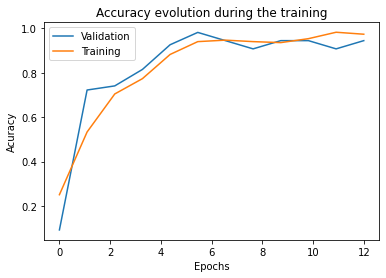

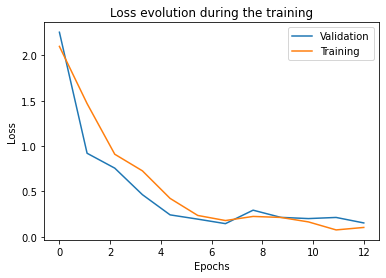

In [272]:

model = FaceResnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), max_lr)
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, num_epochs, criterion, device)
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)